In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import datetime
import math

Load in training data, merge and identify remaining null values

In [0]:
p = lambda x: f'/content/drive/My Drive/MLfinal/{x}'
train_df = pd.read_csv(p('train.csv'))
weather_df = pd.read_csv(p('updated_weather.csv'))
building_metadata_df = pd.read_csv(p('building_metadata.csv'))

In [0]:
building_meter_data = train_df.merge(building_metadata_df, how = 'left', on='building_id')

In [0]:
merged_data = building_meter_data.merge(weather_df, how = 'left', on=['timestamp', 'site_id'])

In [0]:
def print_density(data, name="Data"):
  print(f"{name} Density:")
  for column in data.columns:
    density = str(100 * (len(data) - np.sum(data[column].isnull())) / len (data))
    print(column + ': ' + density)
  print('\n')

print_density(merged_data, "Training Data")

Training Data Density:
building_id: 100.0
meter: 100.0
timestamp: 100.0
meter_reading: 100.0
site_id: 100.0
primary_use: 100.0
square_feet: 100.0
year_built: 40.00996730328797
floor_count: 17.347228199306493
air_temperature: 99.9915958073021
dew_temperature: 99.9915958073021
wind_direction: 99.9915958073021
wind_speed: 99.9915958073021
year: 99.9915958073021
month: 99.9915958073021
day: 99.9915958073021
hour: 99.9915958073021




Remove columns that don't have a lot of meaning for the model or are very sparse

In [0]:
merged_data = merged_data.sort_values(by=['building_id', 'meter','timestamp'])

In [0]:
merged_data.drop(columns=['year', 'year_built', 'floor_count', 'day', 'month'], inplace=True)

Add lag values

In [0]:
merged_data["timestamp"] = [datetime.datetime.strptime(time_stamp, '%Y-%m-%d %H:%M:%S') for time_stamp in merged_data["timestamp"]]

In [0]:
# merged_data['timestamp_new'] = merged_data['timestamp'] + np.timedelta64(-1, 'h')
# merged_data['timestamp_2'] = merged_data['timestamp'] + np.timedelta64(-2, 'h')
merged_data['timestamp_3'] = merged_data['timestamp'] + np.timedelta64(-3, 'h')

In [0]:
merged_data_2 = merged_data.merge(merged_data[['building_id','timestamp','site_id','meter','air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction']], how = 'left', 
                                   left_on=['building_id','timestamp_3', 'site_id','meter'], 
                                   right_on=['building_id','timestamp', 'site_id','meter'],suffixes=('','_3'))

In [0]:
# merged_data_2 = merged_data.merge(merged_data[['building_id','timestamp','site_id','meter','air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction']], how = 'left', 
#                                    left_on=['building_id','timestamp_new', 'site_id','meter'], 
#                                    right_on=['building_id','timestamp', 'site_id','meter'],suffixes=('','_1')).merge(merged_data[['building_id','timestamp','site_id','meter','air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction']], how = 'left', 
#                                    left_on=['building_id','timestamp_2', 'site_id','meter'], 
#                                    right_on=['building_id','timestamp', 'site_id','meter'],suffixes=('','_2')).merge(merged_data[['building_id','timestamp','site_id','meter','air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction']], how = 'left', 
#                                    left_on=['building_id','timestamp_3', 'site_id','meter'], 
#                                    right_on=['building_id','timestamp', 'site_id','meter'],suffixes=('','_3'))

Not a great way to estimate floor count or year built

*Try three approaches: leave null values; set to -999, remove columns*


In [0]:
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

One-Hot Encode Categorical Attributes

In [0]:
daymap = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3 : 'Thursday',4: 'Friday',5: 'Saturday', 6: 'Sunday'}
merged_data_2["weekday"] = merged_data_2['timestamp'].map(lambda timestamp: daymap[timestamp.weekday()]) 

In [0]:
monthmap = {1: 'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
merged_data_2["weekday"] = merged_data_2['timestamp'].map(lambda timestamp: monthmap[timestamp.month]) 

In [0]:
merged_data_2.drop(columns=['wind_direction', 'wind_direction_3', 'dew_temperature', 'dew_temperature_3', 'site_id', 'timestamp_3', 'timestamp', 'building_id'], inplace=True)

In [0]:
merged_data_2['temperature_adjusted'] = merged_data_2['air_temperature'].map(lambda x: np.sqrt((x - 21)**2))

In [0]:
merged_data_2["meter"] = merged_data_2.meter.astype('category')

In [0]:
merged_data_2 = pd.get_dummies(merged_data_2, prefix='', prefix_sep='')

Look at column relationships

In [0]:
import matplotlib.pyplot as plt

Pre-one-hot encoding

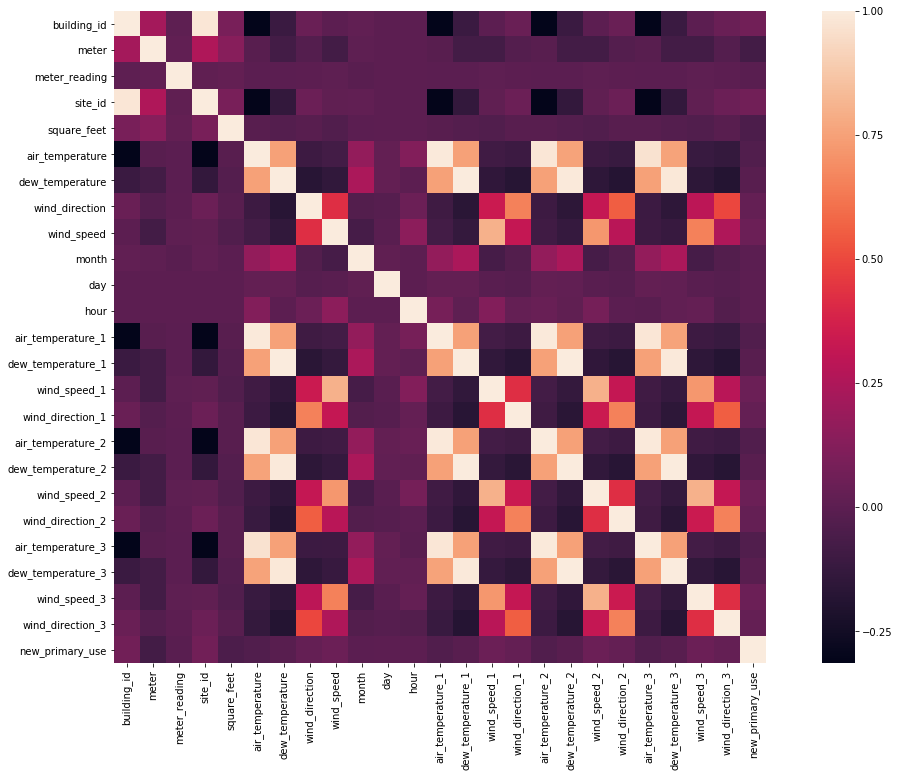

In [0]:
# corr_mat = merged_data_2.corr() 
# fig, ax = plt.subplots(figsize=(20, 12)) 
# sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

With one-hot encoding:

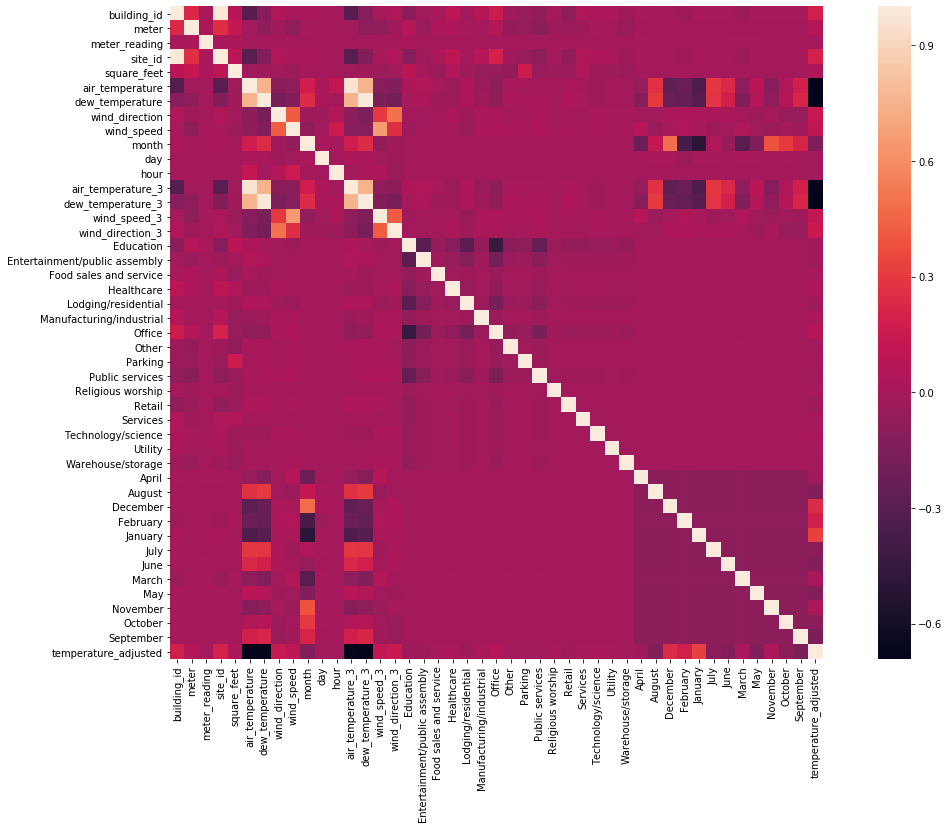

In [0]:
corr_mat = merged_data_2.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

In [0]:
corr_mat.meter_reading.sort_values()

month                           -0.006681
Office                          -0.005471
air_temperature_3               -0.004212
air_temperature_2               -0.004173
air_temperature_1               -0.004134
Lodging/residential             -0.004133
air_temperature                 -0.004099
Entertainment/public assembly   -0.003809
Public services                 -0.003573
dew_temperature_3               -0.003329
dew_temperature_2               -0.003318
dew_temperature_1               -0.003311
dew_temperature                 -0.003309
Other                           -0.001422
Parking                         -0.001314
Healthcare                      -0.001276
Warehouse/storage               -0.001004
Retail                          -0.000966
Manufacturing/industrial        -0.000945
Food sales and service          -0.000891
Technology/science              -0.000802
Sunday                          -0.000786
Saturday                        -0.000676
Utility                         -0

Take every 3 rows as test data (to ensure both training and test have all buildings and full range of timestamps)

In [0]:
data = merged_data_2.iloc[3:].copy()
test = data.iloc[::3, :]
print(test.shape)


(6738699, 40)


In [0]:
train = data[np.mod(np.arange(data.index.size),3) != 0]

Dew temp and air temp correlated; choose air temp

same with windspeed and wind direction, keep wind direction

keep current and lag 3

In [2]:
import numpy as np
import pandas as pd
import datetime
import math

import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [0]:
p = lambda x: f'/content/drive/My Drive/MLfinal/{x}'
train = pd.read_csv(p('updated_train.csv'))
test = pd.read_csv(p('updated_test.csv'))


In [0]:
train.dropna(inplace=True)

In [0]:
test.dropna(inplace=True)

In [0]:
train_labels = train.meter_reading
test_labels = test.meter_reading

In [0]:
train_dataset = train.drop(columns=['meter_reading'])
test_data = test.drop(columns = ['meter_reading'])

Use non-normalized data for linear regression (normalized is too computationally heavy and won't store on drive)

In [0]:
# train_means = train_dataset.mean(axis = 0)
# train_std = train_dataset.std(axis = 0)

In [0]:
# train_stats = train_dataset.describe()
# train_stats = train_stats.transpose()

In [0]:
# normalize data
def norm(x):
  return (x - train_means) / train_std

In [0]:
# first = norm(train_dataset.iloc[:6738699,])
# second = norm(train_dataset.iloc[6738699:,])

In [0]:
# normed_train_data = pd.concat([first, second])
# normed_test_data = norm(test_data)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='linear'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [9]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [11]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[164.47627],
       [164.88339],
       [164.90167],
       [165.0588 ],
       [164.87563],
       [164.86327],
       [164.76938],
       [164.67812],
       [163.61064],
       [163.42659]], dtype=float32)

In [13]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vobc9y4u
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vobc9y4u
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80507 sha256=264b79fdc70d786603d372848e79bb2b7931d0f3af8ec14e8be65070207c1fcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-s1c07gwh/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

First Attempt

In [0]:
EPOCHS = 8

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:29363546199.0593,  mean_absolute_error:2633.5088,  mean_squared_error:29360125952.0000,  val_loss:1874720.0834,  val_mean_absolute_error:552.7137,  val_mean_squared_error:1874723.1250,  
........

In [0]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
3,2.936351e+10,2637.043457,2.936008e+10,1.881114e+06,543.701660,1881116.750,3
4,2.936351e+10,2636.735352,2.936001e+10,1.875722e+06,551.187927,1875717.250,4
5,2.936350e+10,2637.472168,2.935997e+10,1.872441e+06,556.401123,1872435.125,5
6,2.936351e+10,2636.864258,2.935991e+10,1.876469e+06,550.078918,1876465.625,6
7,2.936350e+10,2637.421387,2.936014e+10,1.872392e+06,556.485168,1872381.375,7


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

6738699/6738699 - 308s - loss: 23470041427.2198 - mean_absolute_error: 2223.2319 - mean_squared_error: 23469461504.0000
Testing set Mean Abs Error: 2223.23 MPG


In [0]:
test_predictions = model.predict(normed_test_data).flatten()

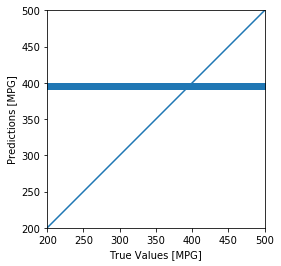

In [0]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [200, 500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

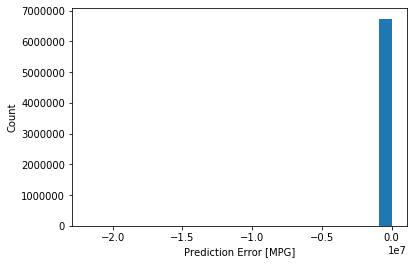

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Second Attempt

non-normalized data bc null values and linear regression it might not matter: https://stats.stackexchange.com/questions/189652/is-it-a-good-practice-to-always-scale-normalize-data-for-machine-learning

In [16]:
EPOCHS = 12

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:29416385546.4782,  mean_absolute_error:2763.4272,  mean_squared_error:29412864000.0000,  val_loss:1565990.6122,  val_mean_absolute_error:589.9000,  val_mean_squared_error:1565988.7500,  
............

In [17]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
7,2.941280e+10,2825.982178,2.940909e+10,1.513192e+06,607.556519,1513199.125,7
8,2.941269e+10,2823.465332,2.940903e+10,1.537554e+06,534.667664,1537550.375,8
9,2.941257e+10,2824.220947,2.940887e+10,1.514616e+06,567.306030,1514605.000,9
10,2.941243e+10,2825.684814,2.940864e+10,1.656868e+06,504.799896,1656860.875,10
11,2.941272e+10,2819.437500,2.940894e+10,1.579913e+06,552.639038,1579920.000,11


In [18]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

6725131/6725131 - 310s - loss: 23509715635.1817 - mean_absolute_error: 2237.7983 - mean_squared_error: 23509225472.0000
Testing set Mean Abs Error: 2237.80 MPG


In [0]:
test_predictions = model.predict(test_data).flatten()

(array([6.410000e+02, 3.088600e+04, 3.993310e+05, 1.162886e+06,
        1.510339e+06, 1.159932e+06, 7.895680e+05, 5.671200e+05,
        3.964920e+05, 2.675060e+05, 1.737630e+05, 9.729200e+04,
        5.024800e+04, 2.975700e+04, 2.284800e+04, 1.892700e+04,
        1.745100e+04, 1.395000e+04, 7.630000e+03, 3.458000e+03,
        2.439000e+03, 1.693000e+03, 6.930000e+02, 2.150000e+02,
        6.600000e+01]),
 array([-1123.7432 ,  -873.62335,  -623.5036 ,  -373.38382,  -123.26402,
          126.85576,   376.97556,   627.09534,   877.2151 ,  1127.335  ,
         1377.4547 ,  1627.5745 ,  1877.6942 ,  2127.814  ,  2377.9338 ,
         2628.0537 ,  2878.1733 ,  3128.2932 ,  3378.413  ,  3628.5327 ,
         3878.6526 ,  4128.7725 ,  4378.892  ,  4629.0117 ,  4879.132  ,
         5129.2515 ], dtype=float32),
 <a list of 25 Patch objects>)

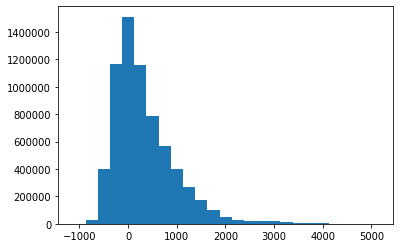

In [22]:
plt.hist(test_predictions, bins = 25)

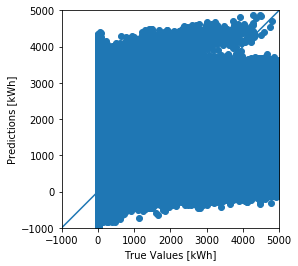

In [50]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [kWh]')
plt.ylabel('Predictions [kWh]')
lims = [-1000, 5000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [40]:
print(test_predictions.min())
print(test_predictions.max())
train_labels.sort_values()[-3:][::-1]

-1123.7432
5129.2515


9174815    21904700.0
9174767    21889900.0
9174766    21874500.0
Name: meter_reading, dtype: float64

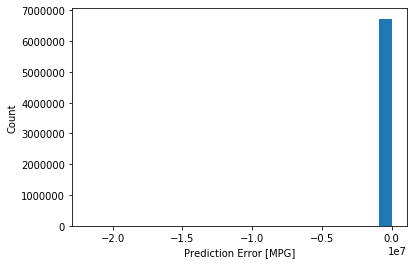

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [56]:
np.sum(train_labels == 0)/len(train_labels)

0.09260339933254083